## Training CNN or DNN on MNIST and Noisy MNIST dataset (n-MNIST)

- A DNN network
- A Simple CNN network
- A Normal CNN network

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

### The neuros setting of hidden layer

In [2]:
neuros = 500
# neuros = 200

### 1, Deep Neural Network (DNN)

In [3]:
class DNNNet(nn.Module):
    def __init__(self):
        super(DNNNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):

        x = x.view(-1, 28 * 28 * 1)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### 2, Simple Convolutional Neural Network(SCNN)

In [4]:
class SimpleCNNNet(nn.Module):
    def __init__(self):
        super(SimpleCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.fc1 = nn.Linear(12 * 12 * 20, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 12 * 12 * 20)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### 3, Convolutional Neural Network (CNN)

In [5]:
class CNNNet(nn.Module):

    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Training Models

In [6]:
#!/usr/bin/env python
"""
Train a basic MNIST CNN.
Based on the PyTorch example code here:
https://github.com/pytorch/examples/blob/master/mnist/main.py
"""
from __future__ import print_function
import os
import sys
import argparse
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import errno
import scipy.io as sio
import numpy as np

#### 1, Training the models on MNIST datasets

In [7]:
from torchvision.datasets import MNIST
from torchvision.datasets.utils import download_url

#### 2,Training the models on Noisy MNIST dataset

In [8]:
class NMNIST(MNIST):
    """`n-MNIST <http://www.csc.lsu.edu/~saikat/n-mnist/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``mnist-with-awgn.mat``,
            ``mnist-with-motion-blur.mat`` and
            ``mnist-with-reduced-contrast-and-awgn.mat`` exist.
        train (bool, optional): If True, loads training data, otherwise loads
            test data.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        dataset (string, optional): Select the particular n-MNIST dataset to load:
            "awgn", "motion-blur", "reduced-contrast-and-awgn" or "all".
    """
    urls = {
        'awgn': 'http://www.csc.lsu.edu/~saikat/n-mnist/data/mnist-with-awgn.gz',
        'motion-blur': 'http://www.csc.lsu.edu/~saikat/n-mnist/data/mnist-with-motion-blur.gz',
        'reduced-contrast-and-awgn': 'http://www.csc.lsu.edu/~saikat/n-mnist/data/mnist-with-reduced-contrast-and-awgn.gz',
    }

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, dataset='awgn'):
        self.dataset = dataset

        if self.dataset != 'all':
            self.urls = {self.dataset: self.urls[self.dataset]}

        self.gzip_files = []
        self.mat_files = []
        for _, url in self.urls.items():
            self.gzip_files.append(os.path.basename(url))
            self.mat_files.append(os.path.splitext(os.path.basename(url))[0] + '.mat')

        self.training_file = self.dataset + '-training.pt'
        self.test_file = self.dataset + '-test.pt'
        print('----0', root)
        super(NMNIST, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)

    def _check_gzips_exists(self):
        for gzip_file in self.gzip_files:
            print('----4',os.path.join('', self.raw_folder, gzip_file))
            if not os.path.exists(os.path.join('', self.raw_folder, gzip_file)):
                return False
        return True

    def _check_mats_exists(self):
        for mat_file in self.mat_files:
            print('----5',os.path.join('', self.raw_folder, mat_file))
            if not os.path.exists(os.path.join('', self.raw_folder, mat_file)):
                return False
        return True

    def download(self):
        """Download the n-MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import tarfile

        if self._check_exists():
            return

        # download files
        try:
            print('----1',os.path.join('', self.raw_folder))
            os.makedirs(os.path.join('', self.raw_folder))
            print('----2',os.path.join('', self.processed_folder))
            os.makedirs(os.path.join('', self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        if not self._check_mats_exists():
            for _, url in self.urls.items():
                filename = url.rpartition('/')[2]
                file_path = os.path.join('', self.raw_folder, filename)
                print('----3',os.path.join('', self.raw_folder, filename))
                print('----4',os.path.join('', self.raw_folder))
                if not self._check_gzips_exists():
                    download_url(url, root=os.path.join('', self.raw_folder),
                                 filename=filename, md5=None)
                with open(file_path.replace('.gz', '.mat'), 'wb') as out_f:
                    tar = tarfile.open(file_path, 'r:gz')
                    zip_f = tar.extractfile(os.path.basename(file_path.replace('.gz', '.mat')))
                    out_f.write(zip_f.read())
                    os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        def read_images(mat_data, split):
            length = mat_data[split].shape[0]
            num_rows = np.uint8(np.sqrt(mat_data[split].shape[1]))
            num_cols = num_rows
            return torch.from_numpy(mat_data[split]).view(length, num_rows, num_cols)

        def read_labels(mat_data, split):
            length = mat_data[split].shape[0]
            labels = np.asarray([np.where(r == 1)[0][0] for r in mat_data[split]])
            return torch.from_numpy(labels).view(length).long()

        data = sio.loadmat(os.path.join('', self.raw_folder, self.mat_files[0]))
        if len(self.mat_files) > 1:
            for mat_file in self.mat_files[1:]:
                mat_data = sio.loadmat(os.path.join('', self.raw_folder, mat_file))
                data['train_x'] = np.concatenate((data['train_x'], mat_data['train_x']), axis=0)
                data['train_y'] = np.concatenate((data['train_y'], mat_data['train_y']), axis=0)
                data['test_x'] = np.concatenate((data['test_x'], mat_data['test_x']), axis=0)
                data['test_y'] = np.concatenate((data['test_y'], mat_data['test_y']), axis=0)

        training_set = (
            read_images(data, 'train_x'),
            read_labels(data, 'train_y')
        )
        test_set = (
            read_images(data, 'test_x'),
            read_labels(data, 'test_y')
        )
        with open(os.path.join('', self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join('', self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

In [9]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if False:
                break

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return round((100. * correct / len(test_loader.dataset)),3)

In [11]:
# hpyerparameters settings
learning_rate = 0.01
step_size=1
gamma=0.7
momentum = 0.5
epoch_num = 10
seed = 1
train_batch_size = 64
test_batch_size = 1000
model_save_path = '../cnn_trained/' 
net_list = ['dnn', 'scnn', 'cnn']

In [12]:
def execute_train(dataset, epoch_num=10):
    
    accuracys = []
    dataset_name = ''
    for net in net_list:
        print('=====================', net,'======================')
        # Training settings
        use_cuda = not False and torch.cuda.is_available()
        accuracy_list = []
        torch.manual_seed(seed)

        device = torch.device("cuda" if use_cuda else "cpu")

        kwargs = {}
        if use_cuda:
            torch.cuda.manual_seed(seed)
            kwargs = {'num_workers': 1,'pin_memory': True}

        # load the mnist dataset
        if dataset == 'mnist':
            data_path = './data/mnist/'
            dataset_name = 'mnist'
            train_loader = torch.utils.data.DataLoader(
                datasets.MNIST(data_path, 
                               train=True, 
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])),
                batch_size=train_batch_size, shuffle=True, **kwargs)

            test_loader = torch.utils.data.DataLoader(
                datasets.MNIST(data_path,
                               train=False,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Normalize((0.1307,), (0.3081,))])),
                batch_size=test_batch_size, shuffle=True, **kwargs)
        # load the n-mnist dataset
        elif dataset == 'awgn' or 'motion-blur' or 'reduced-contrast-and-awgn':
            data_path = './data/n-mnist/'
            dataset_name = 'mnist-' + dataset
            train_loader = torch.utils.data.DataLoader(
                NMNIST(data_path,
                       train=True,
                       download=True,
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.1307,), (0.3081,))]),
                       dataset=dataset),batch_size=train_batch_size, shuffle=True, **kwargs)

            test_loader = torch.utils.data.DataLoader(
                NMNIST(data_path,
                       train=False,
                       download=False,
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.1307,), (0.3081,))]),
                       dataset=dataset), batch_size=test_batch_size, shuffle=True, **kwargs)
            

        if net == 'dnn':
            model = DNNNet().to(device)
        elif net == 'scnn':
            model = SimpleCNNNet().to(device)
        elif net == 'cnn':
            model = CNNNet().to(device)

        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        for epoch in range(1, epoch_num + 1):
            train(None, model, device, train_loader, optimizer, epoch)
            acc = test(model, device, test_loader)
            accuracy_list.append(acc)

        if True:
            if net == 'dnn':
                torch.save(model.state_dict(), model_save_path+'mnist_dnn_net_'+ str(neuros)+ '('+ dataset_name +')' + ".pt")
            elif net == 'scnn':
                torch.save(model.state_dict(), model_save_path+"mnist_cnn_net_simple_"+ str(neuros)+ '('+ dataset_name +')' + ".pt")
            elif net == 'cnn':
                torch.save(model.state_dict(), model_save_path+"mnist_cnn_net_"+ str(neuros)+ '('+ dataset_name +')' + ".pt")
        accuracys.append(accuracy_list)
    
    image_save_path = model_save_path + 'net_' + str(neuros) +'('+ dataset + ')' + '.png'
    # output the accuracys
    print(accuracys)
    return accuracys, image_save_path


In [13]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="darkgrid")

In [14]:
def plot_image(accuracys, image_save_path):
    x = range(1, epoch_num+1)
    plt.figure(figsize=(6,4))
    y1 = accuracys[0]
    y2 = accuracys[1]
    y3 = accuracys[2]
    plt.plot(x, y1, label='DNN', linestyle='dotted', linewidth=2)
    plt.plot(x, y2, label='SCNN', linestyle='dashdot', linewidth=2)
    plt.plot(x, y3, label='CNN')
    ax = plt.subplot()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))
    plt.yticks(np.arange(85, 101, 1.5))
    plt.xticks(np.arange(0, epoch_num+1, 1))
    plt.legend(loc='lower right')
    plt.xlabel('Epochs', fontsize='14')
    plt.ylabel('Accuracy(%)', fontsize='14')
    # plt.title('The accuracy of the different depth neural network')
    # plt.show()
    
    plt.savefig(image_save_path)

#### 1, Training on MNIST dataset

In [15]:
dataset = 'mnist' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
accuracys,image_save_path = execute_train(dataset, epoch_num)

===================== dnn ======================
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348172


/Users/shengdaolin_sh/dir_install/Aanconda3/anaconda3/envs/env_msc_project_py38/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.305550

Test set: Average loss: 0.2543, Accuracy: 9279/10000 (92.790%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.221719
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.206188

Test set: Average loss: 0.1896, Accuracy: 9468/10000 (94.680%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.228009
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.071709

Test set: Average loss: 0.1514, Accuracy: 9572/10000 (95.720%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.135707
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.184974

Test set: Average loss: 0.1319, Accuracy: 9636/10000 (96.360%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.117966
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.086117

Test set: Average loss: 0.1157, Accuracy: 9669/10000 (96.690%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.047692
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.085535

Test set: Average loss: 0.1039, Accuracy: 9702/10000 (97.020%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.096532
Train Epoch: 7 [32000/60000 (53%)]	Loss:

/Users/shengdaolin_sh/dir_install/Aanconda3/anaconda3/envs/env_msc_project_py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.147748

Test set: Average loss: 0.1222, Accuracy: 9659/10000 (96.590%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.151136
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.042912

Test set: Average loss: 0.0744, Accuracy: 9772/10000 (97.720%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.096912
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.059661

Test set: Average loss: 0.0573, Accuracy: 9818/10000 (98.180%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.081806
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.050363

Test set: Average loss: 0.0507, Accuracy: 9844/10000 (98.440%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.016661
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.016297

Test set: Average loss: 0.0510, Accuracy: 9843/10000 (98.430%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.006718
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.033519

Test set: Average loss: 0.0391, Accuracy: 9867/10000 (98.670%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.007650
Train Epoch: 7 [32000/60000 (53%)]	Loss:

[[92.79, 94.68, 95.72, 96.36, 96.69, 97.02, 97.06, 97.31, 97.46, 97.45, 97.57, 97.71, 97.73, 97.8, 97.91, 97.98, 97.8, 97.98, 98.1, 98.06], [96.59, 97.72, 98.18, 98.44, 98.43, 98.67, 98.79, 98.64, 98.82, 98.86, 98.8, 98.91, 98.98, 98.88, 98.88, 98.81, 98.92, 98.99, 99.09, 98.88], [96.74, 97.82, 98.4, 98.62, 98.77, 98.8, 98.86, 98.54, 99.07, 98.88, 99.16, 99.09, 99.25, 99.07, 99.21, 99.11, 99.16, 99.1, 99.16, 99.22]]


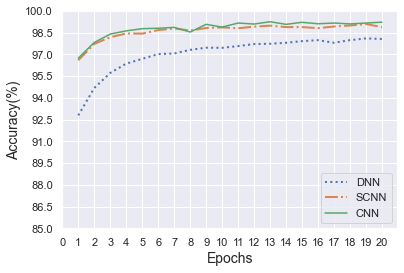

In [16]:
accuracys
print(accuracys)
plot_image(accuracys, image_save_path)

#### 2, Training on Noisy MNIST with AWGN dataset (n-MNIST-AWGN)

In [17]:
dataset = 'awgn' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
accuracys_awgn,image_save_path = execute_train(dataset, epoch_num)

===================== dnn ======================
----0 ./data/n-mnist/
----0 ./data/n-mnist/
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305805
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.316052

Test set: Average loss: 0.3519, Accuracy: 8950/10000 (89.500%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.305354
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.533873

Test set: Average loss: 0.2987, Accuracy: 9109/10000 (91.090%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.338250
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.301545

Test set: Average loss: 0.2576, Accuracy: 9222/10000 (92.220%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.161575
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.185538

Test set: Average loss: 0.2287, Accuracy: 9313/10000 (93.130%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.270964
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.089987

Test set: Average loss: 0.2074, Accuracy: 9370/10000 (93.700%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.189466
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.140427

Test set: A

Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.012384

Test set: Average loss: 0.0477, Accuracy: 9831/10000 (98.310%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.061251
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.006081

Test set: Average loss: 0.0507, Accuracy: 9843/10000 (98.430%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.005727
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.051523

Test set: Average loss: 0.0468, Accuracy: 9838/10000 (98.380%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.003647
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.004641

Test set: Average loss: 0.0483, Accuracy: 9842/10000 (98.420%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.010268
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.033985

Test set: Average loss: 0.0533, Accuracy: 9836/10000 (98.360%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.002242
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.017018

Test set: Average loss: 0.0477, Accuracy: 9845/10000 (98.450%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.011326
Train Epoch: 16 [32000/60000

[[89.5, 91.09, 92.22, 93.13, 93.7, 94.27, 94.65, 94.74, 94.95, 94.94, 95.11, 95.06, 95.28, 95.27, 95.25, 95.31, 95.44, 95.35, 95.44, 95.42], [92.95, 95.13, 95.53, 96.56, 97.24, 97.59, 97.42, 97.44, 97.84, 97.86, 97.69, 98.04, 97.86, 97.88, 97.92, 97.95, 97.99, 98.01, 97.93, 98.11], [95.21, 97.24, 97.47, 97.91, 98.06, 98.1, 98.32, 98.23, 98.26, 98.31, 98.43, 98.38, 98.42, 98.36, 98.45, 98.42, 98.36, 98.5, 98.53, 98.45]]


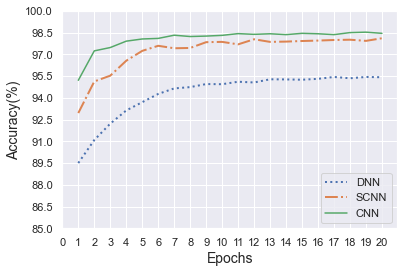

In [18]:
accuracys_awgn
print(accuracys_awgn)
plot_image(accuracys_awgn, image_save_path)

#### 3 Training on Noisy MNIST with Motion Blur dataset (n-MNIST-MB)

In [19]:
dataset = 'motion-blur' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
accuracys_mb,image_save_path = execute_train(dataset, epoch_num)

===================== dnn ======================
----0 ./data/n-mnist/
----0 ./data/n-mnist/
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323592
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.191395

Test set: Average loss: 0.2856, Accuracy: 9156/10000 (91.560%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.282000
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.403156

Test set: Average loss: 0.2170, Accuracy: 9374/10000 (93.740%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.228689
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.257531

Test set: Average loss: 0.1755, Accuracy: 9493/10000 (94.930%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.146174
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.146564

Test set: Average loss: 0.1516, Accuracy: 9569/10000 (95.690%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.219344
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.068383

Test set: Average loss: 0.1348, Accuracy: 9607/10000 (96.070%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.118702
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.116400

Test set: A

Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.008663

Test set: Average loss: 0.0378, Accuracy: 9876/10000 (98.760%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.085058
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.005900

Test set: Average loss: 0.0324, Accuracy: 9893/10000 (98.930%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.003921
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.018032

Test set: Average loss: 0.0346, Accuracy: 9895/10000 (98.950%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.004523
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.024305

Test set: Average loss: 0.0337, Accuracy: 9890/10000 (98.900%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.004022
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.016207

Test set: Average loss: 0.0415, Accuracy: 9870/10000 (98.700%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.017973
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.002613

Test set: Average loss: 0.0316, Accuracy: 9895/10000 (98.950%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.012809
Train Epoch: 16 [32000/60000

[[91.56, 93.74, 94.93, 95.69, 96.07, 96.35, 96.74, 96.89, 97.02, 97.1, 97.07, 97.14, 97.45, 97.33, 97.36, 97.48, 97.51, 97.5, 97.62, 97.71], [94.6, 96.84, 96.82, 97.94, 97.9, 98.18, 98.34, 98.28, 98.44, 98.5, 98.39, 98.52, 98.66, 98.67, 98.58, 98.7, 98.65, 98.71, 98.69, 98.77], [95.52, 97.14, 98.03, 98.31, 98.38, 98.59, 98.68, 98.53, 98.64, 98.76, 98.93, 98.95, 98.9, 98.7, 98.95, 98.71, 98.93, 98.94, 99.02, 98.87]]


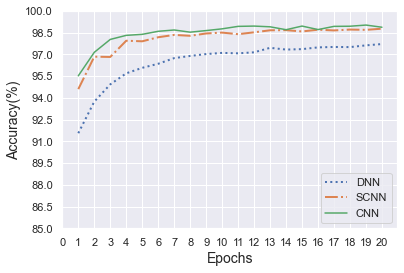

In [20]:
accuracys_mb
print(accuracys_mb)
plot_image(accuracys_mb, image_save_path)

#### 4, Training on Noisy MNIST with Reduced Contrast and AWGN dataset (n-MNIST-RC-AWGN)

In [21]:
dataset = 'reduced-contrast-and-awgn' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
accuracys_rc_awgn,image_save_path = execute_train(dataset, epoch_num)

===================== dnn ======================
----0 ./data/n-mnist/
----0 ./data/n-mnist/
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.281987
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.455812

Test set: Average loss: 0.4881, Accuracy: 8538/10000 (85.380%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.539180
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.722668

Test set: Average loss: 0.4374, Accuracy: 8667/10000 (86.670%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.337119
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.441257

Test set: Average loss: 0.4082, Accuracy: 8750/10000 (87.500%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.334616
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.422412

Test set: Average loss: 0.3875, Accuracy: 8784/10000 (87.840%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.630884
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.238458

Test set: Average loss: 0.3619, Accuracy: 8878/10000 (88.780%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.346135
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.273608

Test set: A

Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.022357

Test set: Average loss: 0.0835, Accuracy: 9709/10000 (97.090%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.095840
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.041249

Test set: Average loss: 0.0865, Accuracy: 9714/10000 (97.140%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.065403
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.055280

Test set: Average loss: 0.0949, Accuracy: 9694/10000 (96.940%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.028092
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.059398

Test set: Average loss: 0.0814, Accuracy: 9740/10000 (97.400%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.047754
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.022952

Test set: Average loss: 0.0809, Accuracy: 9746/10000 (97.460%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.024792
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.049881

Test set: Average loss: 0.0779, Accuracy: 9741/10000 (97.410%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.014436
Train Epoch: 16 [32000/60000

[[85.38, 86.67, 87.5, 87.84, 88.78, 89.38, 89.81, 90.47, 90.89, 91.11, 91.59, 91.83, 92.02, 91.94, 92.26, 92.21, 92.3, 92.54, 92.58, 92.72], [88.79, 91.93, 94.03, 93.74, 95.54, 95.14, 95.77, 95.68, 95.97, 96.27, 96.09, 96.18, 96.55, 96.27, 96.52, 96.56, 96.67, 96.64, 96.16, 96.72], [92.21, 94.9, 95.74, 96.16, 96.32, 96.42, 97.06, 97.06, 96.67, 97.09, 97.14, 96.94, 97.4, 97.46, 97.41, 97.48, 97.54, 97.37, 97.22, 97.31]]


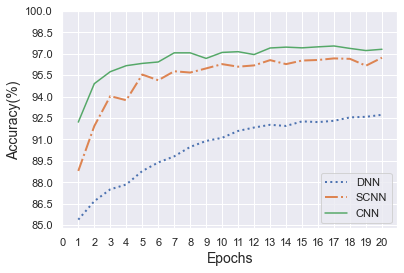

In [22]:
accuracys_rc_awgn
print(accuracys_rc_awgn)
plot_image(accuracys_rc_awgn, image_save_path)